# Portfolio Manager Simulation with Greed Parameter

## Summary

This notebook simulates portfolio managers with varying levels of "greed" - the tendency to deviate from optimal Kelly criterion betting based on recent performance. Using S&P 500 data and Monte Carlo methods, we analyze how behavioral biases affect portfolio survival and performance.

## Methodology Overview

### 1. Data Preparation and Distribution Fitting
We fit S&P 500 log returns to a Student-t distribution with parameters $(\nu, \mu, \sigma)$:

$$r_t \sim t_\nu(\mu, \sigma^2)$$

### 2. Scenario Generation and Kelly Ratio Construction
**Key Innovation**: We generate scenarios and then **shift** them to construct specific optimal Kelly ratios.

For each target Kelly ratio $f^*$, we solve for the return shift $\delta$ such that:

$$\frac{d \mathbb{E}\left[\log(1 + f (R - \delta))\right]}{df} = \mathbb{E}\left[\frac{R - \delta}{1 + f(R - \delta)}\right] = 0$$

where $R$ are the original scenario returns. The shifted scenarios become:
$$R_{shifted} = R - \delta$$

This ensures that $f$ is the true optimal Kelly ratio for the shifted scenarios.

### 3. Portfolio Evolution with Greed Parameter
The portfolio capital evolves according to:

$$C_{t+1} = C_t \cdot [R_{t+1} \cdot f_t + (1 - f_t)]$$

where the invested fraction $f_t$ is determined by the greed parameter $g \in [0,1]$:

$$f_t = f^* \cdot (1 - g) + g \cdot \frac{\max_{0 \leq s \leq t} C_s}{C_t}$$

**Interpretation**:
- $g = 0$: Pure Kelly criterion (optimal)
- $g = 1$: Full momentum betting based on current drawdown from peak
- $0 < g < 1$: Hybrid strategy blending optimal and behavioral components

### 4. Performance Metrics
We analyze:
- **Mean log final capital**: $\mathbb{E}[\log C_T]$
- **Survival rate**: $P(\max_{0 \leq t \leq T} \log C_t - \log C_T < \log(5))$ (avoid >80% drawdown)
- **Maximum drawdown**: $\max_{0 \leq t \leq T} \left(\max_{0 \leq s \leq t} \log C_s - \log C_t\right)$
- **Return skewness**: Asymmetry of $\Delta \log C_t$ distribution

### Mathematical Framework Summary
The complete system is:
$$\begin{align}
\text{Scenarios:} \quad & R_t^{(i)} \sim \text{Student-t fitted to S\&P 500} \\
\text{Shifting:} \quad & \tilde{R}_t^{(i)} = R_t^{(i)} - \delta(f^*) \\
\text{Kelly condition:} \quad & \mathbb{E}\left[\frac{\tilde{R}}{1 + f^* \tilde{R}}\right] = 0 \\
\text{Greed model:} \quad & f_t = f^*(1-g) + g \cdot \frac{\max_{s \leq t} C_s}{C_t} \\
\text{Capital evolution:} \quad & C_{t+1} = C_t[\tilde{R}_{t+1} f_t + (1-f_t)]
\end{align}$$


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from scipy.optimize import root_scalar
from tqdm import tqdm
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
def simulate_portfolio_manager(kelly_ratio, greed_ratio, scenario_returns):
    m, n = scenario_returns.shape
    capital = np.ones((m + 1, n))

    for t in np.arange(1, m + 1):
        invested_ratio = kelly_ratio * (1 - greed_ratio) + greed_ratio * np.max(capital[:t, :], axis=0) / capital[t-1, :]
        invested_ratio = np.clip(invested_ratio, 0, 1)
        capital[t, :] = capital[t-1, :] * scenario_returns[t-1, :] * invested_ratio + capital[t-1, :] * (1 - invested_ratio)
    
    return capital

def compute_max_drawdown(x):
    running_max = np.maximum.accumulate(x, axis=0)
    drawdown = running_max - x
    return drawdown.max(axis=0)

def compute_capital_stats(capital):
    """ Compute mean log final capital, median skewness of the log return, median maximum drawdown and survival rate.
    """
    log_capital = np.log(capital)
    log_return = np.diff(log_capital, axis=0)
    mean_log_final_capital = np.mean(np.log(capital[-1, :]))
    median_skewness = np.median(stats.skew(log_return, axis=0))

    max_drawdown = compute_max_drawdown(log_capital)
    median_max_drawdown = np.median(max_drawdown)
    survival_rate = np.mean(max_drawdown < -np.log(0.8))

    return {
        "mean_log_final_capital": mean_log_final_capital,
        "median_skewness": median_skewness,
        "median_max_drawdown": median_max_drawdown,
        "survival_rate": survival_rate
    }

def simulate_single_combination(kelly_ratio, return_shift, greed_ratio, scenario_returns, simulation_dir):
    """
    Helper function to simulate a single combination of kelly_ratio and greed_ratio
    for parallel processing
    """
    # Run simulation
    capital = simulate_portfolio_manager(kelly_ratio, greed_ratio, scenario_returns - return_shift)
    
    # Create filename with kelly ratio and greed ratio
    filename = f"capital_kelly_{kelly_ratio:.1f}_greed_{greed_ratio:.2f}.npy"
    filepath = os.path.join(simulation_dir, filename)
    
    # Save the capital array
    np.save(filepath, capital)
    
    return f"Kelly {kelly_ratio:.1f}, Greed {greed_ratio:.2f}"

def compute_stats_single_file(kelly_ratio, greed_ratio, simulation_dir):
    """
    Helper function to compute statistics for a single file
    for parallel processing
    """
    filename = f"capital_kelly_{kelly_ratio:.1f}_greed_{greed_ratio:.2f}.npy"
    filepath = os.path.join(simulation_dir, filename)
    capital = np.load(filepath)
    output = compute_capital_stats(capital)
    output["optimal_kelly_ratio"] = kelly_ratio
    output["greed_ratio"] = greed_ratio
    return output


In [3]:
n_scenarios = int(1e5)  # Number of scenarios
horizon = 240  # Days per scenario
kelly_ratios = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] # Optimal Kelly ratios of different market conditions
greed_levels = np.arange(0, 1.01, 0.05) # Greed levels of different portfolio managers

# Create data directory structure
data_dir = "../data"
simulation_dir = os.path.join(data_dir, "portfolio_manager_simulations")
os.makedirs(simulation_dir, exist_ok=True)

print("Running portfolio manager simulations...")
print(f"Results will be saved to: {simulation_dir}")

Running portfolio manager simulations...
Results will be saved to: ../data/portfolio_manager_simulations


## 1. Fetch S&P 500 Data from Yahoo Finance

In [4]:
# Fetch S&P 500 data from 1980
ticker = "^GSPC"
start_date = "1980-01-01"
end_date = "2025-07-14"

# Download data
sp500 = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Calculate log returns
sp500['Log_Return'] = np.log(sp500['Close'] / sp500['Close'].shift(1))
sp500 = sp500.dropna()

print(f"Data fetched from {sp500.index[0].date()} to {sp500.index[-1].date()}")
print(f"Total number of observations: {len(sp500)}")
print(f"\nLog returns statistics:")
print(f"Mean: {sp500['Log_Return'].mean():.6f}")
print(f"Std: {sp500['Log_Return'].std():.6f}")
print(f"Skewness: {stats.skew(sp500['Log_Return']):.6f}")
print(f"Kurtosis: {stats.kurtosis(sp500['Log_Return']):.6f}")


Data fetched from 1980-01-03 to 2025-07-11
Total number of observations: 11474

Log returns statistics:
Mean: 0.000356
Std: 0.011336
Skewness: -1.047751
Kurtosis: 24.175261


## 2. Fit Log Returns to Student-t Distribution

Student-t distribution parameters:
Degrees of freedom (df): 2.9861
Location (loc): 0.000631
Scale: 0.006884


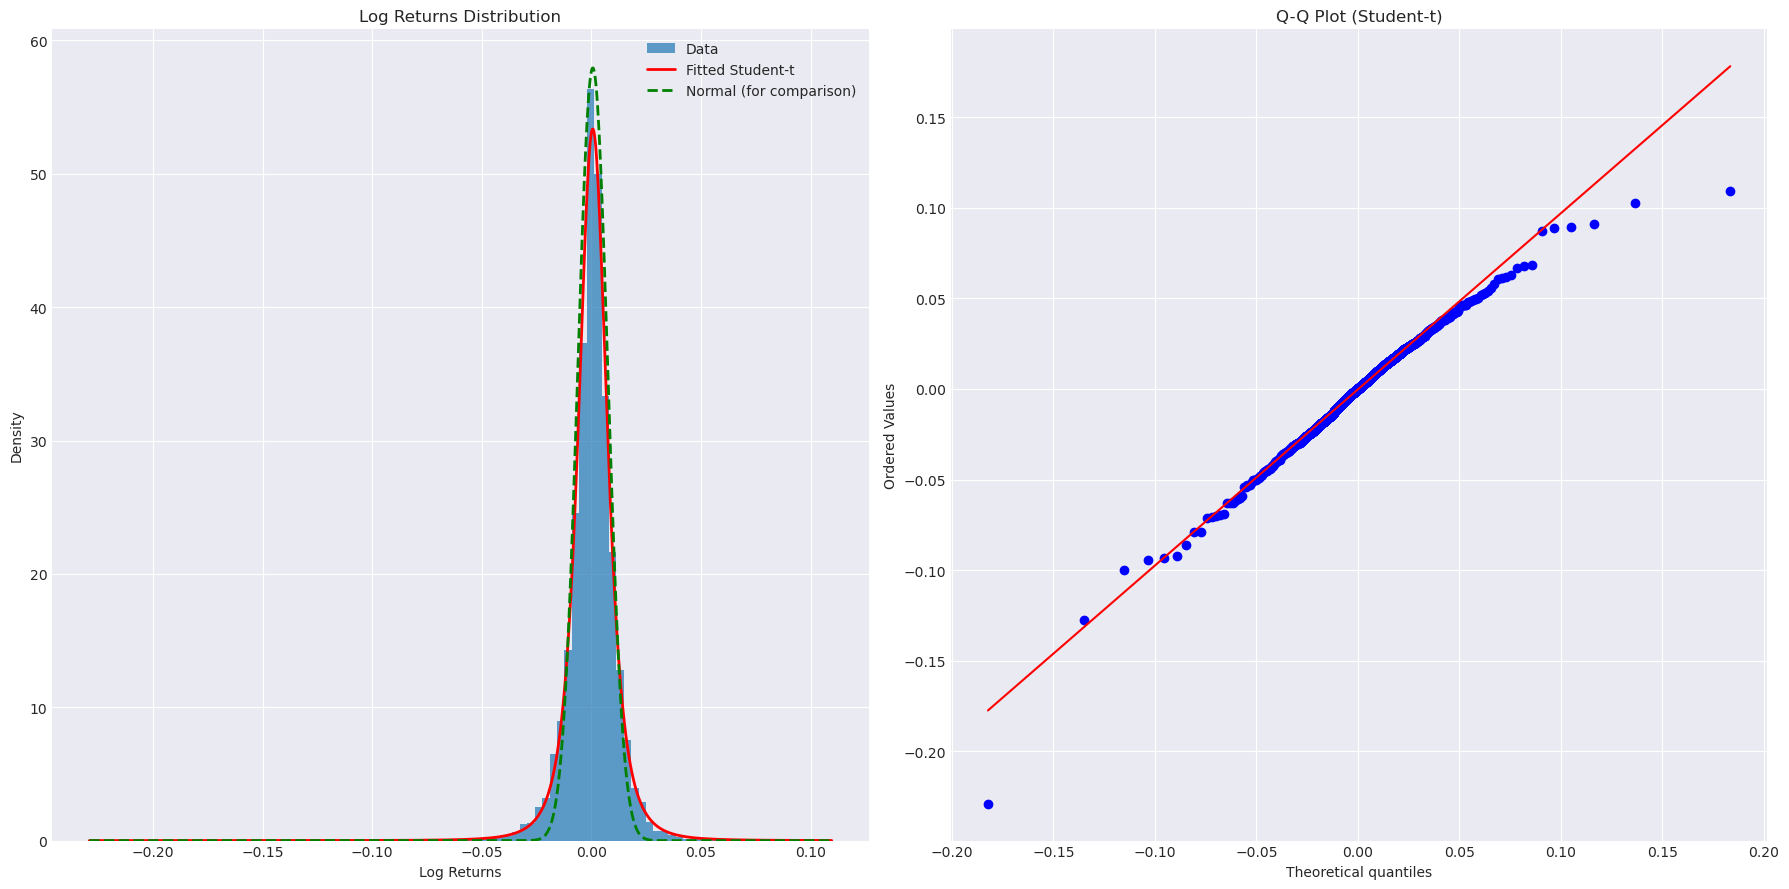

In [5]:
# Fit Student-t distribution to log returns
log_returns = sp500['Log_Return'].values

# Fit Student-t distribution
params = stats.t.fit(log_returns)
df, loc, scale = params

print(f"Student-t distribution parameters:")
print(f"Degrees of freedom (df): {df:.4f}")
print(f"Location (loc): {loc:.6f}")
print(f"Scale: {scale:.6f}")

# Visualize the fit
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# Histogram with fitted distribution
ax1.hist(log_returns, bins=100, density=True, alpha=0.7, label='Data')
x = np.linspace(log_returns.min(), log_returns.max(), 1000)
ax1.plot(x, stats.t.pdf(x, df, loc, scale), 'r-', lw=2, label='Fitted Student-t')
ax1.plot(x, stats.norm.pdf(x, loc, scale), 'g--', lw=2, label='Normal (for comparison)')
ax1.set_xlabel('Log Returns')
ax1.set_ylabel('Density')
ax1.set_title('Log Returns Distribution')
ax1.legend()

# Q-Q plot
stats.probplot(log_returns, dist=stats.t, sparams=(df, loc, scale), plot=ax2)
ax2.set_title('Q-Q Plot (Student-t)')

plt.tight_layout()
plt.show()


## 3. Generate Scenarios Using Student-t Distribution

Generating 100,000 scenarios with 240 days each...
Scenarios generated successfully!
Shape: (240, 100000)

Scenario statistics:
Mean daily log return: 0.000625
Std daily log return: 0.011998


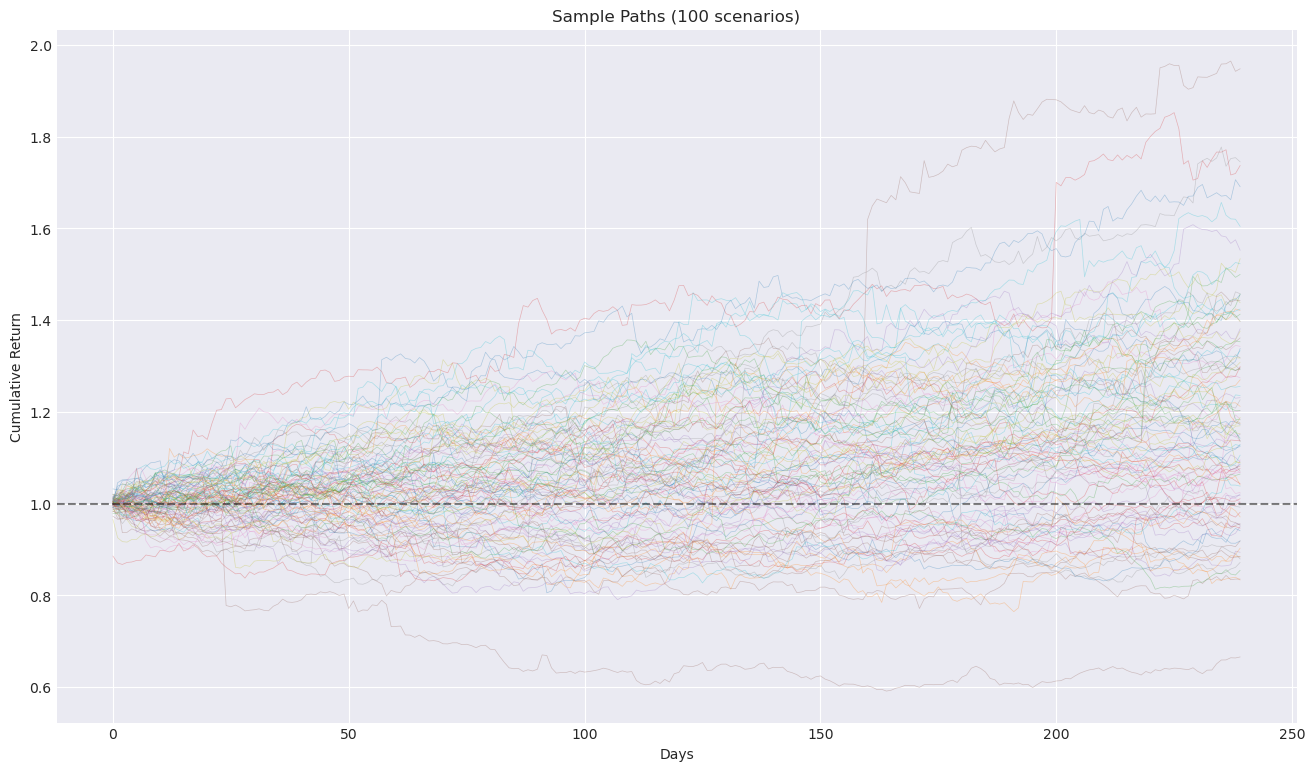

In [6]:
# Generate scenarios
print(f"Generating {n_scenarios:,} scenarios with {horizon} days each...")
scenarios = stats.t.rvs(df, loc=loc, scale=scale, size=(horizon, n_scenarios))

# Convert log returns to price returns
scenario_returns = np.exp(scenarios)

print(f"Scenarios generated successfully!")
print(f"Shape: {scenarios.shape}")
print(f"\nScenario statistics:")
print(f"Mean daily log return: {scenarios.mean():.6f}")
print(f"Std daily log return: {scenarios.std():.6f}")

# Visualize sample paths
fig, ax = plt.subplots(figsize=(16, 9))
sample_indices = np.random.choice(n_scenarios, 100, replace=False)
for i in sample_indices:
    cumulative_returns = np.cumprod(scenario_returns[:, i])
    ax.plot(cumulative_returns, alpha=0.3, linewidth=0.5)

ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Return')
ax.set_title('Sample Paths (100 scenarios)')
ax.axhline(y=1, color='black', linestyle='--', alpha=0.5)
plt.show()


## 4. Compute Optimal Kelly Ratio

In [7]:

# Calculate return shifts needed to achieve target Kelly ratios
# For each target Kelly ratio, we solve for the shift μ such that the Kelly condition is satisfied:
# E[R / (1 + f*R)] = 0, where R = returns - μ and f = kelly_ratio
returns = scenario_returns.flatten() - 1  # Convert price returns to simple returns
return_shifts = []

print("Computing return shifts for target Kelly ratios...")
for i, kelly_ratio in enumerate(kelly_ratios):
    def kelly_gradient(mu):
        """
        Kelly gradient function: E[R / (1 + f*R)] where R = returns - μ
        The optimal Kelly ratio occurs when this gradient equals zero
        """
        adjusted_returns = returns - mu
        return np.mean(adjusted_returns / (1 + kelly_ratio * adjusted_returns))
    
    # Solve for the return shift using root finding
    try:
        solution = root_scalar(kelly_gradient, bracket=[0, 1])
        return_shifts.append(solution.root)
        print(f"Kelly ratio {kelly_ratio:.1f}: return shift = {solution.root:.6f}")
    except ValueError:
        # If bracket doesn't work, try a different approach
        solution = root_scalar(kelly_gradient, method='brentq', bracket=[-0.1, 1])
        return_shifts.append(solution.root)
        print(f"Kelly ratio {kelly_ratio:.1f}: return shift = {solution.root:.6f}")

print(f"\nCompleted calculation for {len(kelly_ratios)} Kelly ratios")

Computing return shifts for target Kelly ratios...
Kelly ratio 0.2: return shift = 0.000668
Kelly ratio 0.3: return shift = 0.000654
Kelly ratio 0.4: return shift = 0.000640
Kelly ratio 0.5: return shift = 0.000625
Kelly ratio 0.6: return shift = 0.000611
Kelly ratio 0.7: return shift = 0.000597
Kelly ratio 0.8: return shift = 0.000582

Completed calculation for 7 Kelly ratios


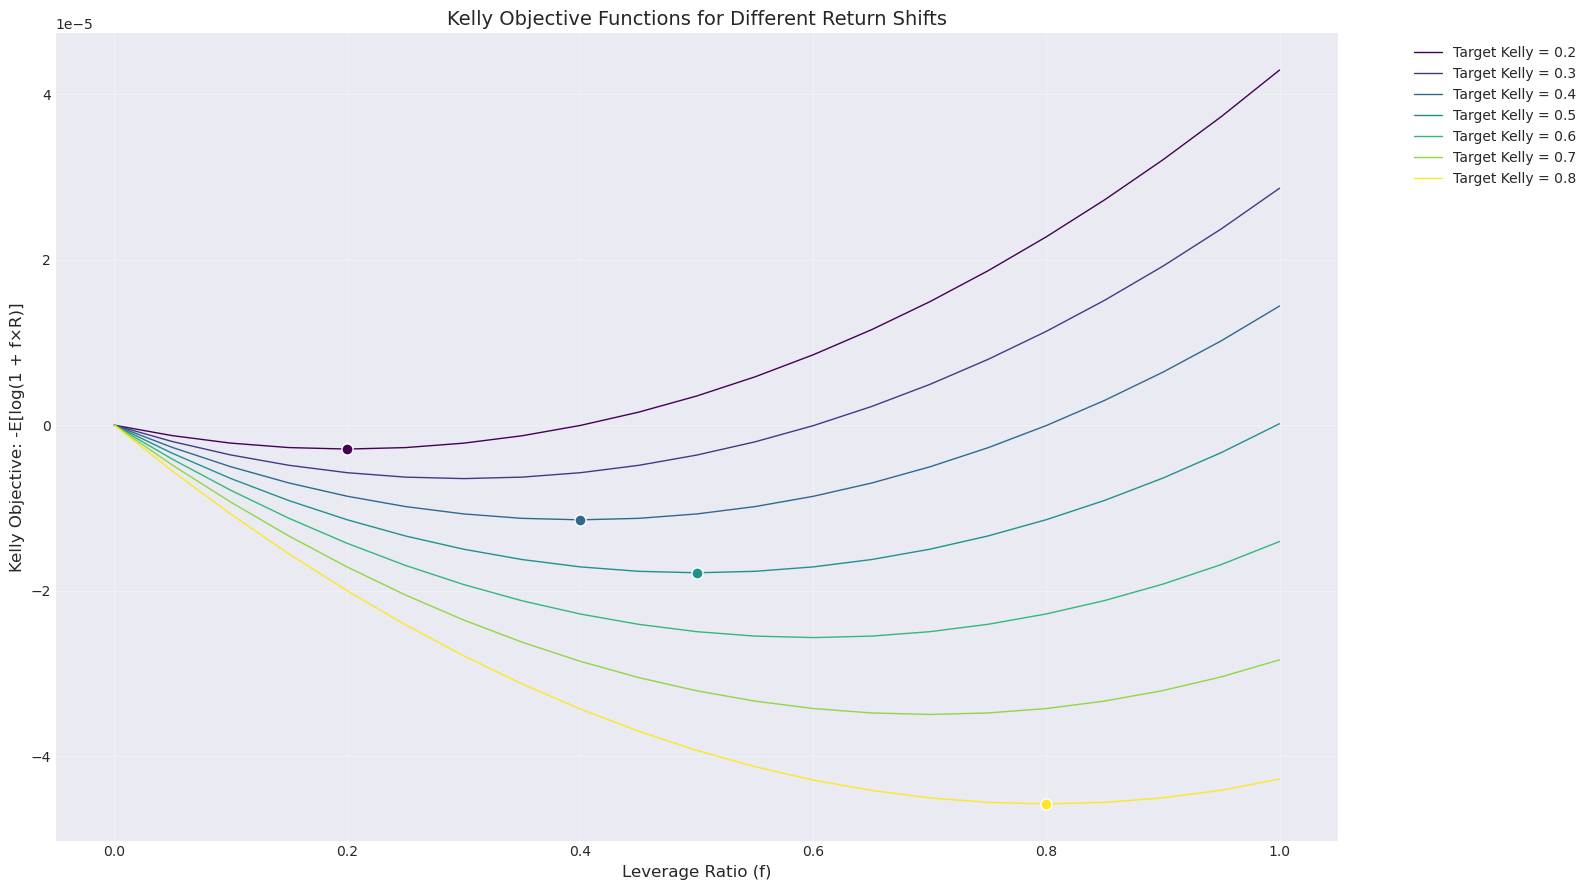


Summary of Kelly Ratios and Return Adjustments:
   Target Kelly Ratio  Required Return Shift  Adjusted Mean Return
0                 0.2               0.000668              0.000029
1                 0.3               0.000654              0.000043
2                 0.4               0.000640              0.000058
3                 0.5               0.000625              0.000072
4                 0.6               0.000611              0.000086
5                 0.7               0.000597              0.000100
6                 0.8               0.000582              0.000115


In [9]:
# Visualize Kelly objective function for different return shifts
# Create visualization of Kelly curves
ratios = np.arange(0, 1.01, 0.05)

def kelly_objective(leverage_ratios, return_shift):
    """
    Kelly objective function: -E[log(1 + f*R)] where R = returns - μ
    We minimize this to find the optimal leverage ratio
    """
    adjusted_returns = returns - return_shift
    fx = np.outer(adjusted_returns, leverage_ratios)
    return -np.mean(np.log(1 + fx), axis=0)

plt.figure(figsize=(16, 9))
colors = plt.cm.viridis(np.linspace(0, 1, len(kelly_ratios)))

for i, (return_shift, target_kelly, color) in enumerate(zip(return_shifts, kelly_ratios, colors)):
    objective_values = kelly_objective(ratios, return_shift)
    plt.plot(ratios, objective_values, 
             label=f'Target Kelly = {target_kelly:.1f}', 
             color=color, linewidth=1)
    
    # Mark the optimal point
    optimal_idx = np.where(ratios == target_kelly)[0]
    if len(optimal_idx) > 0:
        plt.plot(target_kelly, objective_values[optimal_idx[0]], 
                'o', color=color, markersize=8, markeredgecolor='white', markeredgewidth=1)

plt.xlabel('Leverage Ratio (f)', fontsize=12)
plt.ylabel('Kelly Objective: -E[log(1 + f×R)]', fontsize=12)
plt.title('Kelly Objective Functions for Different Return Shifts', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display summary table
summary_df = pd.DataFrame({
    'Target Kelly Ratio': kelly_ratios,
    'Required Return Shift': return_shifts,
    'Adjusted Mean Return': [np.mean(returns) - shift for shift in return_shifts]
})
print("\nSummary of Kelly Ratios and Return Adjustments:")
print(summary_df.round(6))


## 5. Simulate Portfolio Managers with Different Greed Levels

In [10]:
# Run simulations and save results using parallel processing
print("Running simulations in parallel...")

# Create all combinations of kelly_ratios and greed_levels
simulation_tasks = []
for kelly_ratio, return_shift in zip(kelly_ratios, return_shifts):
    for greed_ratio in greed_levels:
        simulation_tasks.append((kelly_ratio, return_shift, greed_ratio, scenario_returns, simulation_dir))

# Run simulations in parallel using all available CPU cores
# n_jobs=-1 uses all available cores
results = Parallel(n_jobs=-1, verbose=1)(
    delayed(simulate_single_combination)(kelly_ratio, return_shift, greed_ratio, scenario_returns, simulation_dir)
    for kelly_ratio, return_shift, greed_ratio, scenario_returns, simulation_dir in simulation_tasks
)

print(f"\nAll simulations completed! Results saved in {simulation_dir}")
print(f"Processed {len(results)} combinations in parallel")

Running simulations in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.3s



All simulations completed! Results saved in ../data/portfolio_manager_simulations
Processed 147 combinations in parallel


[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  1.4min finished


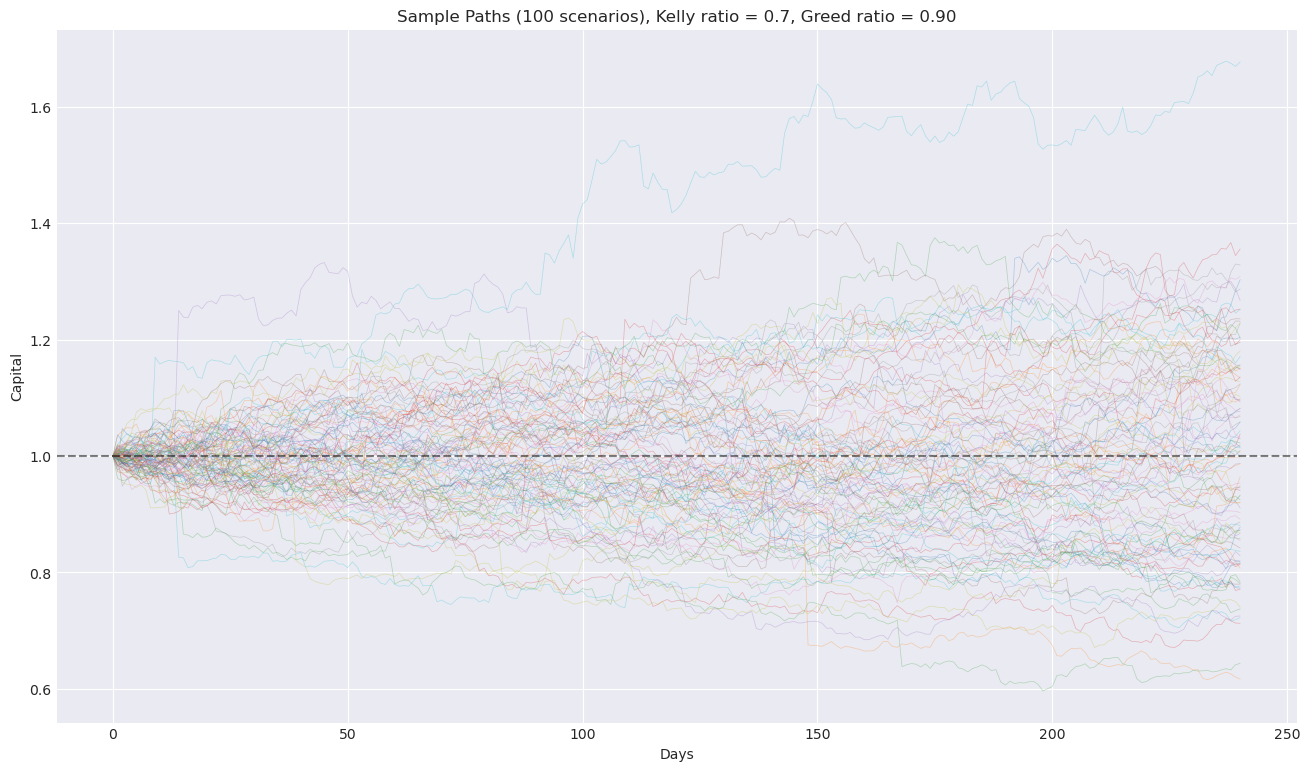

In [11]:
# Visualize portfolio manager simulation
kelly_ratio = 0.7
greed_ratio = 0.9
# Load capital array
filename = f"capital_kelly_{kelly_ratio:.1f}_greed_{greed_ratio:.2f}.npy"
filepath = os.path.join(simulation_dir, filename)
capital = np.load(filepath)

fig, ax = plt.subplots(figsize=(16, 9))
sample_indices = np.random.choice(n_scenarios, 100, replace=False)
for i in sample_indices:
    ax.plot(capital[:, i], alpha=0.3, linewidth=0.5)

ax.set_xlabel('Days')
ax.set_ylabel('Capital')
ax.set_title(f'Sample Paths (100 scenarios), Kelly ratio = {kelly_ratio:.1f}, Greed ratio = {greed_ratio:.2f}')
ax.axhline(y=1, color='black', linestyle='--', alpha=0.5)
plt.show()

## 6. Compute Statistics

In [13]:
# Compute statistics using parallel processing
print("Computing statistics in parallel...")

# Create all combinations for parallel processing
stat_tasks = [(kelly_ratio, greed_ratio, simulation_dir) 
              for kelly_ratio in kelly_ratios 
              for greed_ratio in greed_levels]

total_files = len(stat_tasks)
print(f"Processing {total_files} files...")

# Compute statistics in parallel using all available CPU cores
stats_results = Parallel(n_jobs=-1, verbose=1)(
    delayed(compute_stats_single_file)(kelly_ratio, greed_ratio, simulation_dir)
    for kelly_ratio, greed_ratio, simulation_dir in stat_tasks
)

stats_df = pd.DataFrame(stats_results)
print(f"Computed statistics for {len(stats_results)} files in parallel")


Computing statistics in parallel...
Processing 147 files...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.9s


Computed statistics for 147 files in parallel


[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   43.2s finished


## 7. Visualization of Statistics

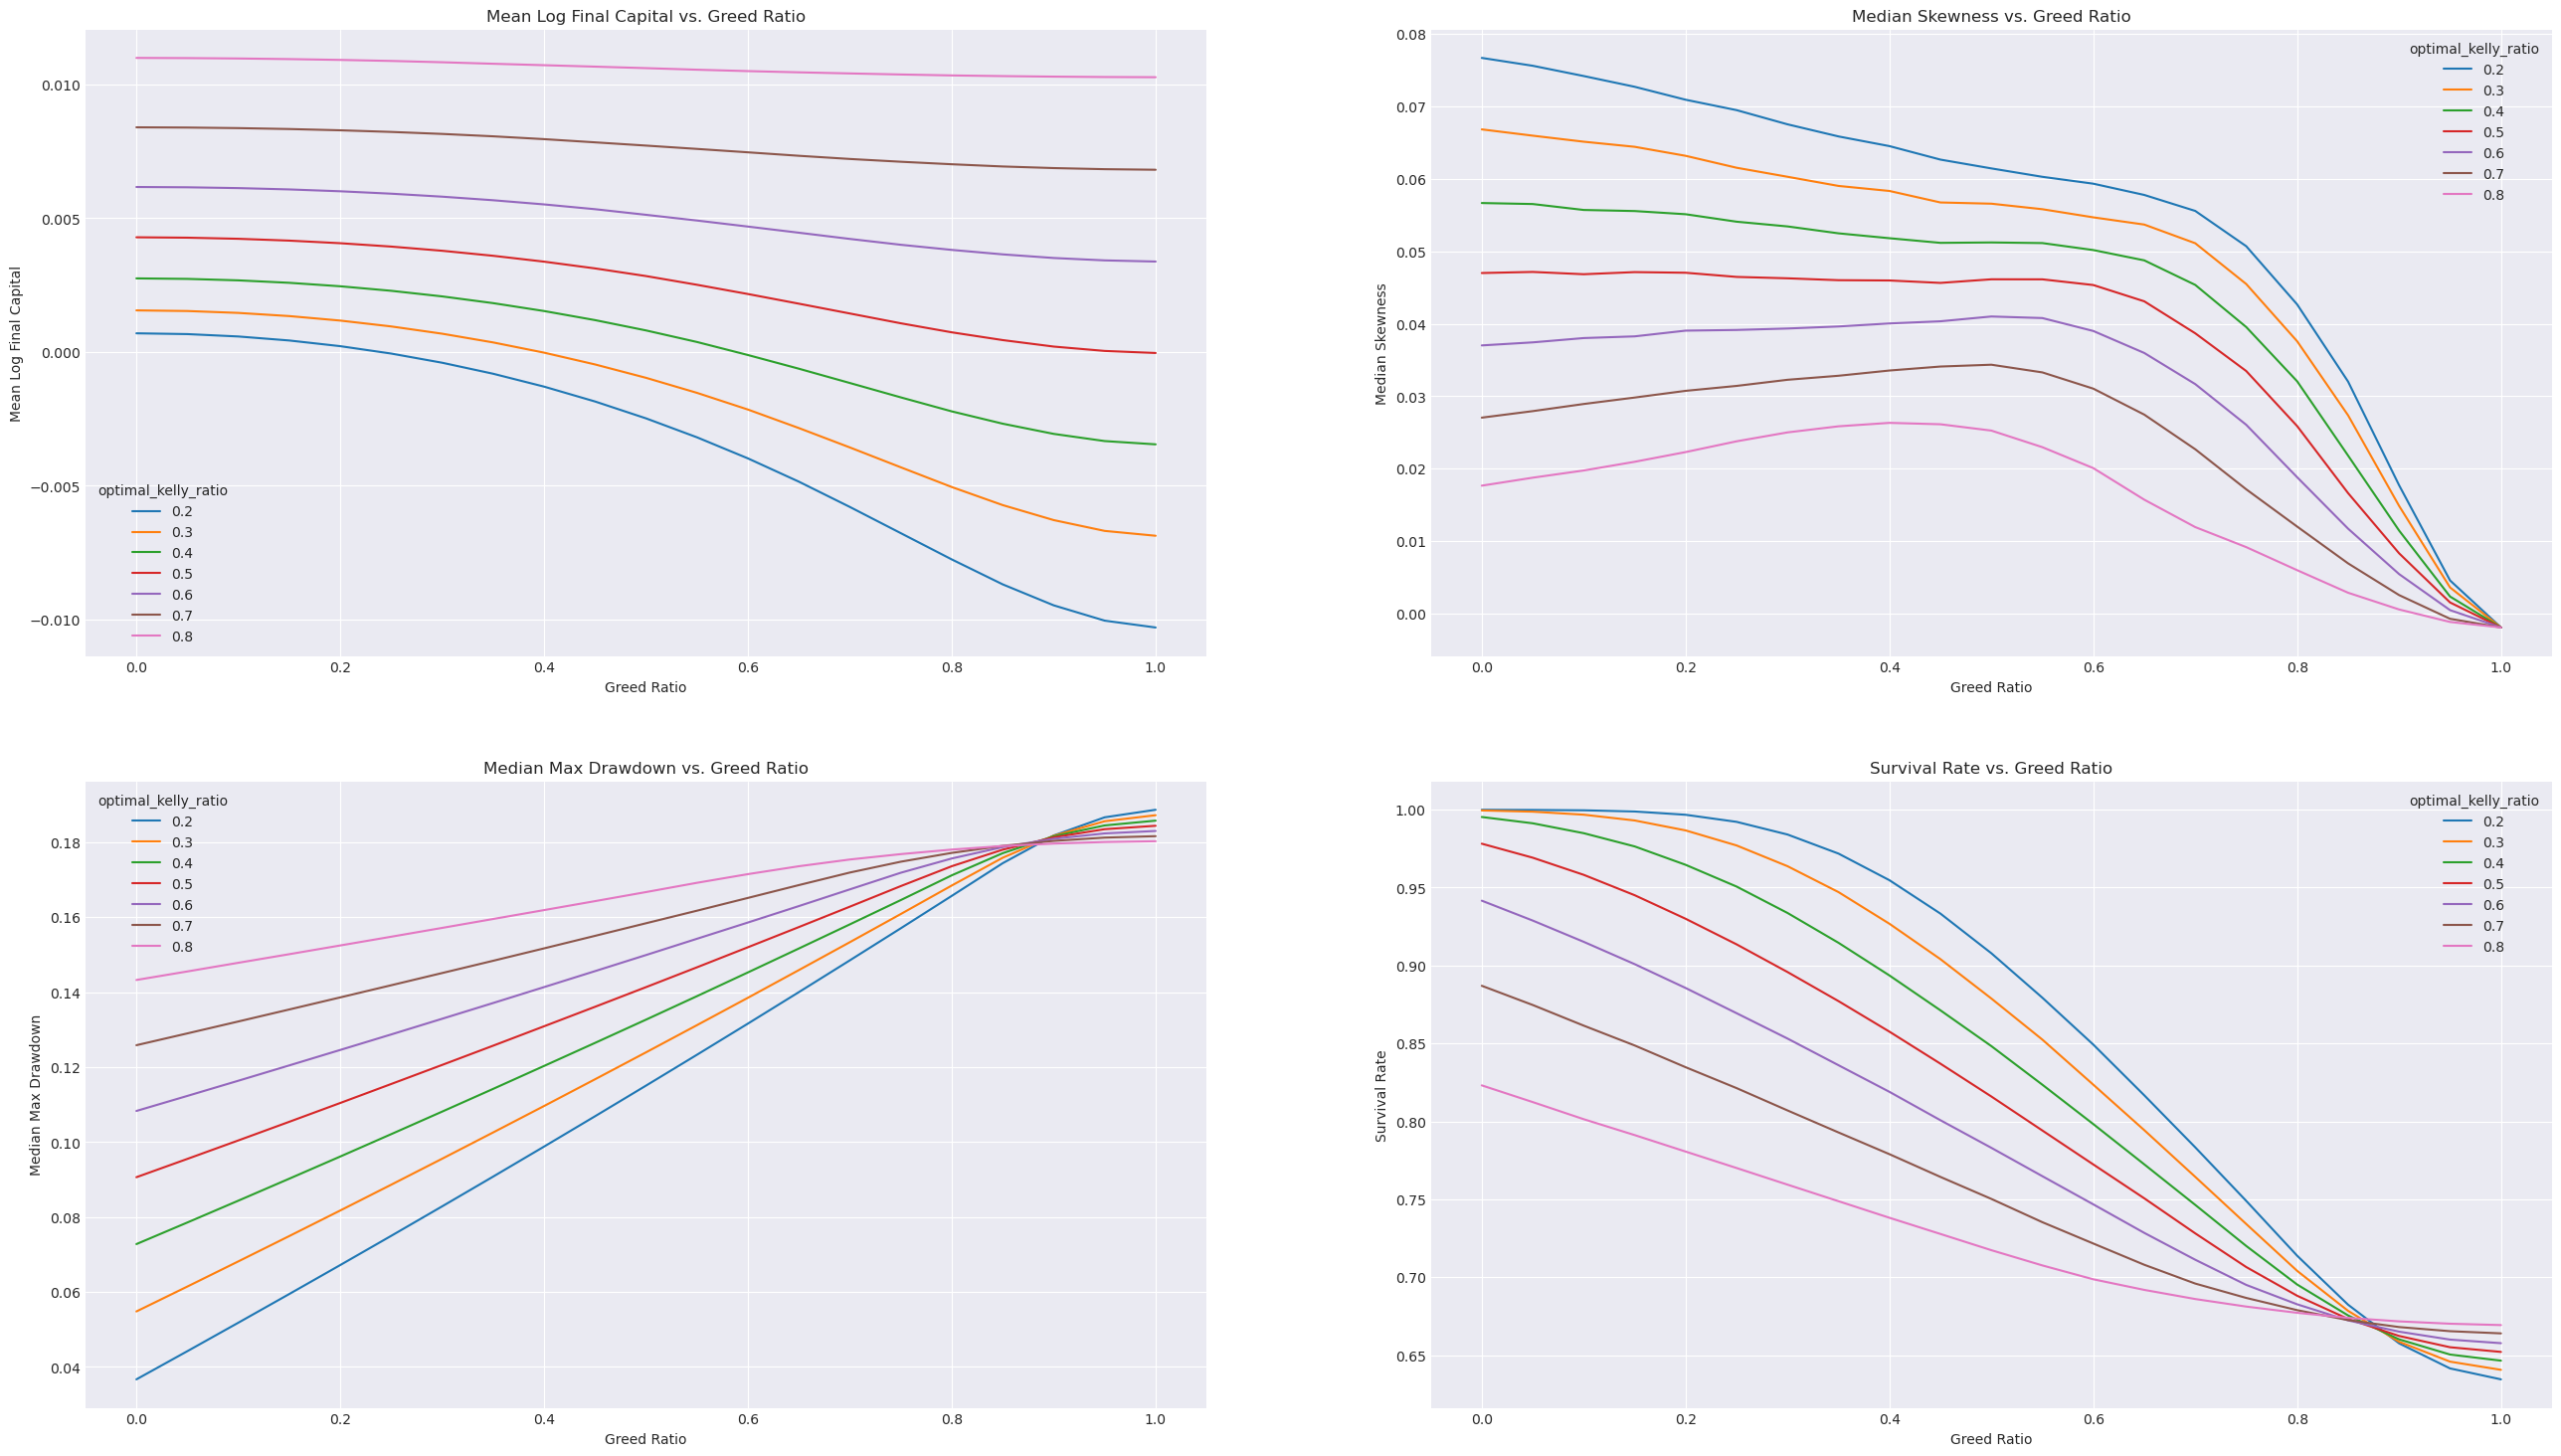

<Figure size 640x480 with 0 Axes>

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(32, 18))
df_plot = stats_df.pivot(index="greed_ratio", columns="optimal_kelly_ratio", values="mean_log_final_capital")
df_plot.plot(ax=axes[0, 0])
axes[0, 0].set_xlabel("Greed Ratio")
axes[0, 0].set_ylabel("Mean Log Final Capital")
axes[0, 0].set_title("Mean Log Final Capital vs. Greed Ratio")

df_plot = stats_df.pivot(index="greed_ratio", columns="optimal_kelly_ratio", values="median_skewness")
df_plot.plot(ax=axes[0, 1])
axes[0, 1].set_xlabel("Greed Ratio")
axes[0, 1].set_ylabel("Median Skewness")
axes[0, 1].set_title("Median Skewness vs. Greed Ratio")

df_plot = stats_df.pivot(index="greed_ratio", columns="optimal_kelly_ratio", values="median_max_drawdown")
df_plot.plot(ax=axes[1, 0])
axes[1, 0].set_xlabel("Greed Ratio")
axes[1, 0].set_ylabel("Median Max Drawdown")
axes[1, 0].set_title("Median Max Drawdown vs. Greed Ratio")

df_plot = stats_df.pivot(index="greed_ratio", columns="optimal_kelly_ratio", values="survival_rate")
df_plot.plot(ax=axes[1, 1])
axes[1, 1].set_xlabel("Greed Ratio")
axes[1, 1].set_ylabel("Survival Rate")
axes[1, 1].set_title("Survival Rate vs. Greed Ratio")
plt.show()
plt.tight_layout()